## Training a second Model

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import joblib

import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    train_vectorizer,
    get_vectorized_series,
    get_feature_vector_and_label
)

from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_confusion_matrix_plot,
    get_calibration_plot
)

from ml_editor.model_v2 import (
    add_char_count_features,
    get_word_stats,
    get_sentiment_score,
    POS_NAMES,
    get_question_score_from_input
)

%load_ext autoreload
%autoreload 2
np.random.seed(42)

data_path=Path("../data/writers.csv")
df=pd.read_csv(data_path)
df=format_raw_df(df.copy())
df=df.loc[df["is_question"]].copy()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\msi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df["full_text"]=df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")


In [3]:
train_df, test_df=get_split_by_author(df, test_size=0.2, random_state=42)


In [4]:
vectorizer=train_vectorizer(train_df)
df["vectors"]=get_vectorized_series(df["full_text"].copy(), vectorizer)

In [5]:
df=add_char_count_features(df.copy())
df=get_word_stats(df.copy())
df=get_sentiment_score(df.copy())

100%|██████████| 7971/7971 [00:31<00:00, 250.69it/s]


In [6]:
feature_arr=[
    "num_questions",
    "num_periods",
    "num_commas",
    "num_exclam",
    "num_colon",
    "num_stops",
    "num_semicolon",
    "num_words",
    "num_chars",
    "num_diff_words",
    "avg_word_len",
    "polarity"
]


feature_arr.extend(POS_NAMES.keys())

## Model

In [7]:
train_df, test_df=get_split_by_author(df, test_size=0.2, random_state=42)


In [8]:
X_train, y_train=get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test=get_feature_vector_and_label(test_df, feature_arr)

In [9]:
y_train.value_counts()

Score
False    3327
True     2889
Name: count, dtype: int64

In [10]:
X_test.shape

(1755, 7586)

In [11]:
clf=RandomForestClassifier(n_estimators=100, class_weight="balanced", oob_score=True)
clf.fit(X_train, y_train)

y_predicted=clf.predict(X_test)
y_predicted_proba=clf.predict_proba(X_test)

In [12]:
def get_metrics(y_test, y_predicted):
    precision=precision_score(y_test, y_predicted, pos_label=True, average='binary')
    recall=recall_score(y_test, y_predicted, pos_label=True, average='binary')
    f1=f1_score(y_test, y_predicted, pos_label=True, average='binary')
    accuracy=accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [13]:
# Training accuracy

y_train_pred=np.argmax(clf.oob_decision_function_, axis=1)

accuracy, precision, recall, f1=get_metrics(y_train, y_train_pred)
print(f"Training accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1_score: {f1:.3f}")

Training accuracy: 0.604, precision: 0.593, recall: 0.472, f1_score: 0.525


In [14]:
# Validation accuracy
accuracy, precision, recall, f1=get_metrics(y_test, y_predicted)
print(f"Validation accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1_score: {f1:.3f}")

Validation accuracy: 0.598, precision: 0.577, recall: 0.515, f1_score: 0.544


In [15]:
model_path=Path("../models/model_2.pkl")
vectorizer_path=Path("../models/vectorizer_2.pkl")
joblib.dump(clf, model_path)
joblib.dump(vectorizer, vectorizer_path)

['..\\models\\vectorizer_2.pkl']

## Validating that features are useful

In [16]:
w_indices=list(vectorizer.get_feature_names_out())
w_indices.extend(feature_arr)
all_feature_names=np.array(w_indices)

In [17]:
k = 20
print(f"Top {k} importances:\n")
print('\n'.join([f"{tup[0]}: {tup[1]:.2g}" for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print(f"\nBottom {k} importances:\n")
print('\n'.join([f"{tup[0]}: {tup[1]:.2g}" for tup in get_feature_importance(clf, all_feature_names)[-k:]]))


Top 20 importances:

num_chars: 0.0081
ADJ: 0.0081
num_diff_words: 0.0075
num_questions: 0.0073
num_periods: 0.0072
ADV: 0.0071
PUNCT: 0.0069
AUX: 0.0066
SCONJ: 0.0063
num_commas: 0.0063
num_stops: 0.0063
NOUN: 0.0061
DET: 0.0061
avg_word_len: 0.0061
PRON: 0.006
num_words: 0.0059
VERB: 0.0058
ADP: 0.0057
PROPN: 0.0056
are: 0.0054

Bottom 20 importances:

illuminating: 0
immoral: 0
immortal: 0
impacts: 0
impose: 0
impress: 0
imprisoned: 0
inconsistencies: 0
austria: 0
incorporated: 0
incorrectly: 0
infamous: 0
infinitely: 0
inhabitants: 0
inject: 0
innovation: 0
insisted: 0
institutions: 0
insulting: 0
00: 0


## Comparing predictions to data

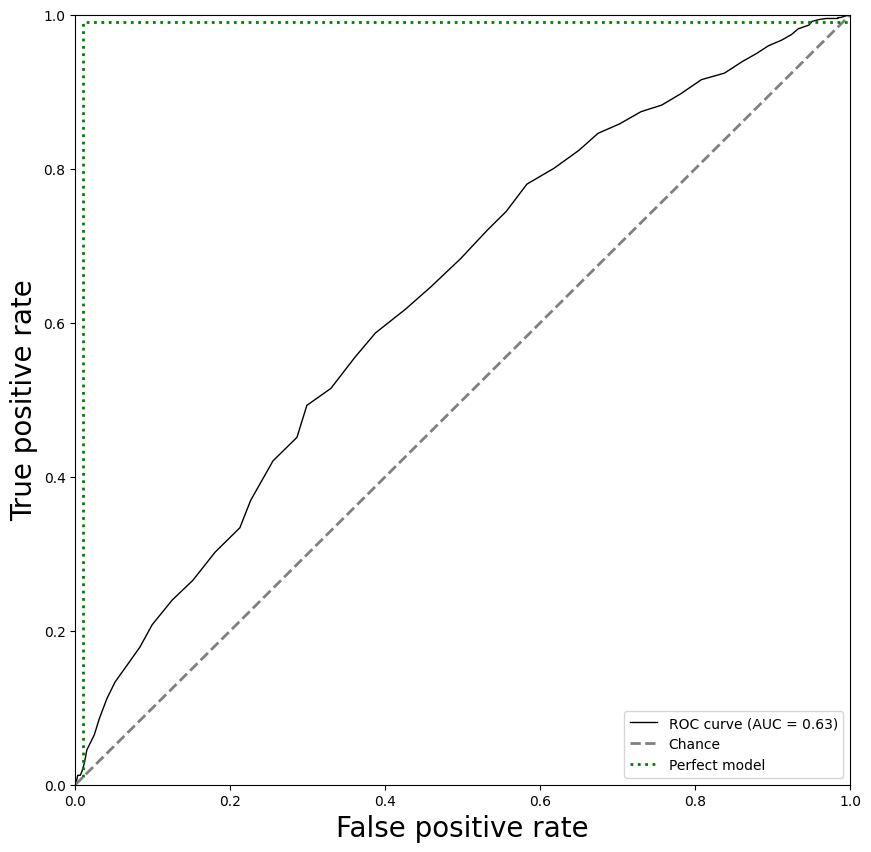

In [18]:
get_roc_plot(y_predicted_proba[:, 1], y_test, figsize=(10, 10))

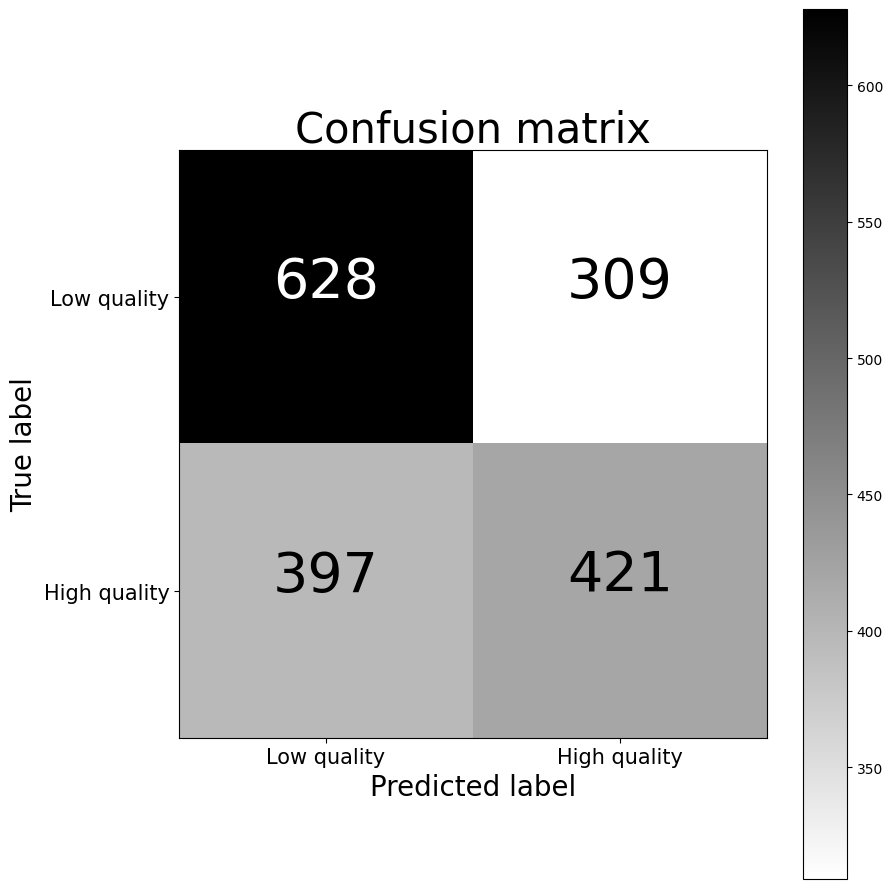

In [19]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9,9))

	Brier: 0.235


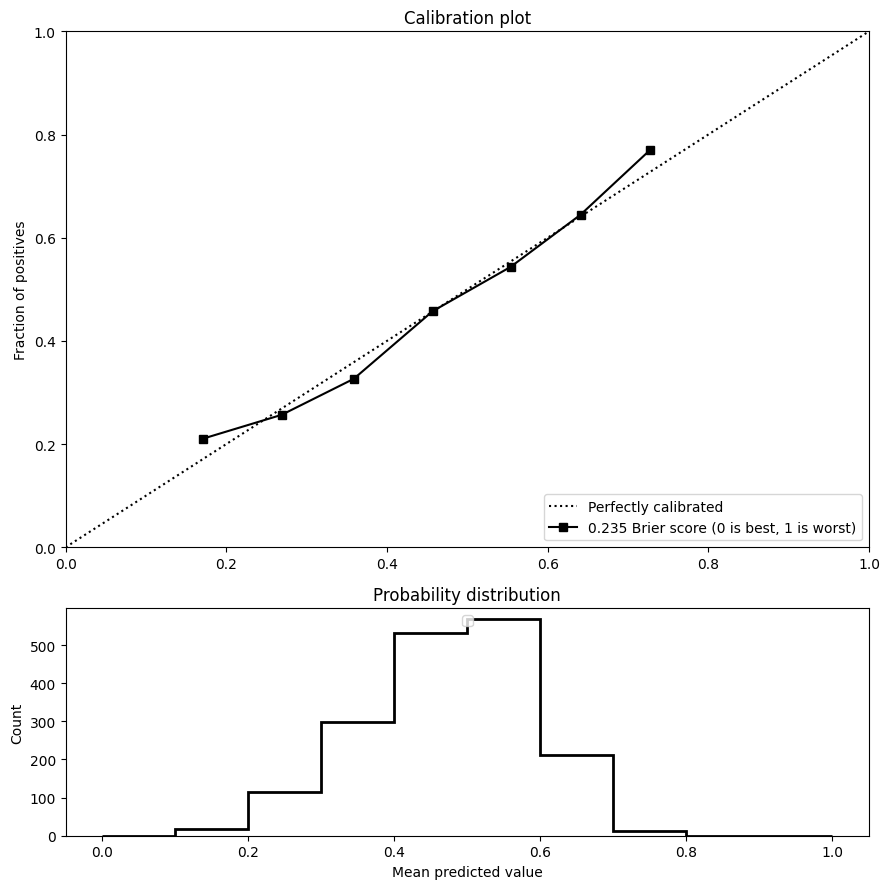

In [20]:
get_calibration_plot(y_predicted_proba[:, 1], y_test, figsize=(9,9))

## Inference Function

In [21]:
pos_prob=get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print(f" Probablity of the question receiving a high score according to our model : {pos_prob}")

100%|██████████| 1/1 [00:00<?, ?it/s]


TypeError: iteration over a 0-d array